In [1]:
import pandas as pd
import numpy as np

from sklearn import feature_selection, pipeline, svm, model_selection, metrics

from skopt import BayesSearchCV

np.int = int  # fix for skopt

import datamol as dm

from rdkit.Chem.Crippen import MolLogP

In [2]:
df_train = pd.read_csv("logP-14000.csv").dropna()

smi = df_train.SMILES
len(smi)

14163

In [3]:
list_smi_canon = []

for smiles in smi:
    mol = dm.to_mol(smiles)
    canon_smi = dm.to_smiles(mol, canonical=True)
    list_smi_canon.append(canon_smi)

len(list_smi_canon)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


14163

In [4]:
df_train.insert(1, "canon_smi", list_smi_canon, False)  # добавили колонку

df_train.drop_duplicates(
    subset="canon_smi", keep="first", inplace=True
)  # удалили дубликаты, оставляя только первое входящее веществоP

y_train = df_train.Kow

### создание fps для Popova

In [5]:
smiles_Popova = df_train.SMILES

mols_Popova = [dm.to_mol(smiles) for smiles in smiles_Popova]

fps_Popova = [
    dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols_Popova
]

X_train = pd.DataFrame(data=np.array(fps_Popova))  # сделаем не только с 0 и 1
X_train

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
fps_Popova_01 = [dm.to_fp(mol, nBits=1024 * 4) for mol in mols_Popova]

X_train_01 = pd.DataFrame(data=np.array(fps_Popova_01))  # сделаем не только с 0 и 1
X_train_01

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### создание fps для Martel

In [7]:
df_test = pd.read_csv("logP-707-Martel.csv")

y_test = df_test.logPow

In [8]:
smiles_Martel = df_test.SMILES

mols_Martel = [dm.to_mol(smiles) for smiles in smiles_Martel]

fps_Martel = [
    dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols_Martel
]

X_test = pd.DataFrame(data=np.array(fps_Martel))
X_test

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
fps_Martel_01 = [dm.to_fp(mol, nBits=1024 * 4) for mol in mols_Martel]

X_test_01 = pd.DataFrame(data=np.array(fps_Martel_01))
X_test_01

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## проверка на соответствие молекул из статьи

In [10]:
MAIN_MOLS = pd.read_csv(
    "MOLS.csv"
)  # работает только на ядре 3.12.1, которе не стоит в рекомендованном
smiles = MAIN_MOLS.SMILES
names = list(MAIN_MOLS.NAME)
names

['Lycorine',
 'Apiol',
 'Dillapiol',
 'ATMB',
 'Myristicin',
 'TPP–apiol',
 'TPP–dillapiol',
 'TPP–ATMB',
 'Propyl–TPP',
 'Allylbenzene',
 'Estragole',
 'Eugenol',
 '1-allyl-1.2.4-triazol',
 '2.5-dimethoxy-3.4-methylenedioxy-4′-methoxychalcon',
 '2.5-dimethoxy-3.4-methylenedioxy-4′.5′-methylenedioxychalcon',
 '2.5-dimethoxy-3.4-methylenedioxy-4′-fluorochalcon']

In [11]:
mols = [dm.to_mol(smiles) for smiles in smiles]

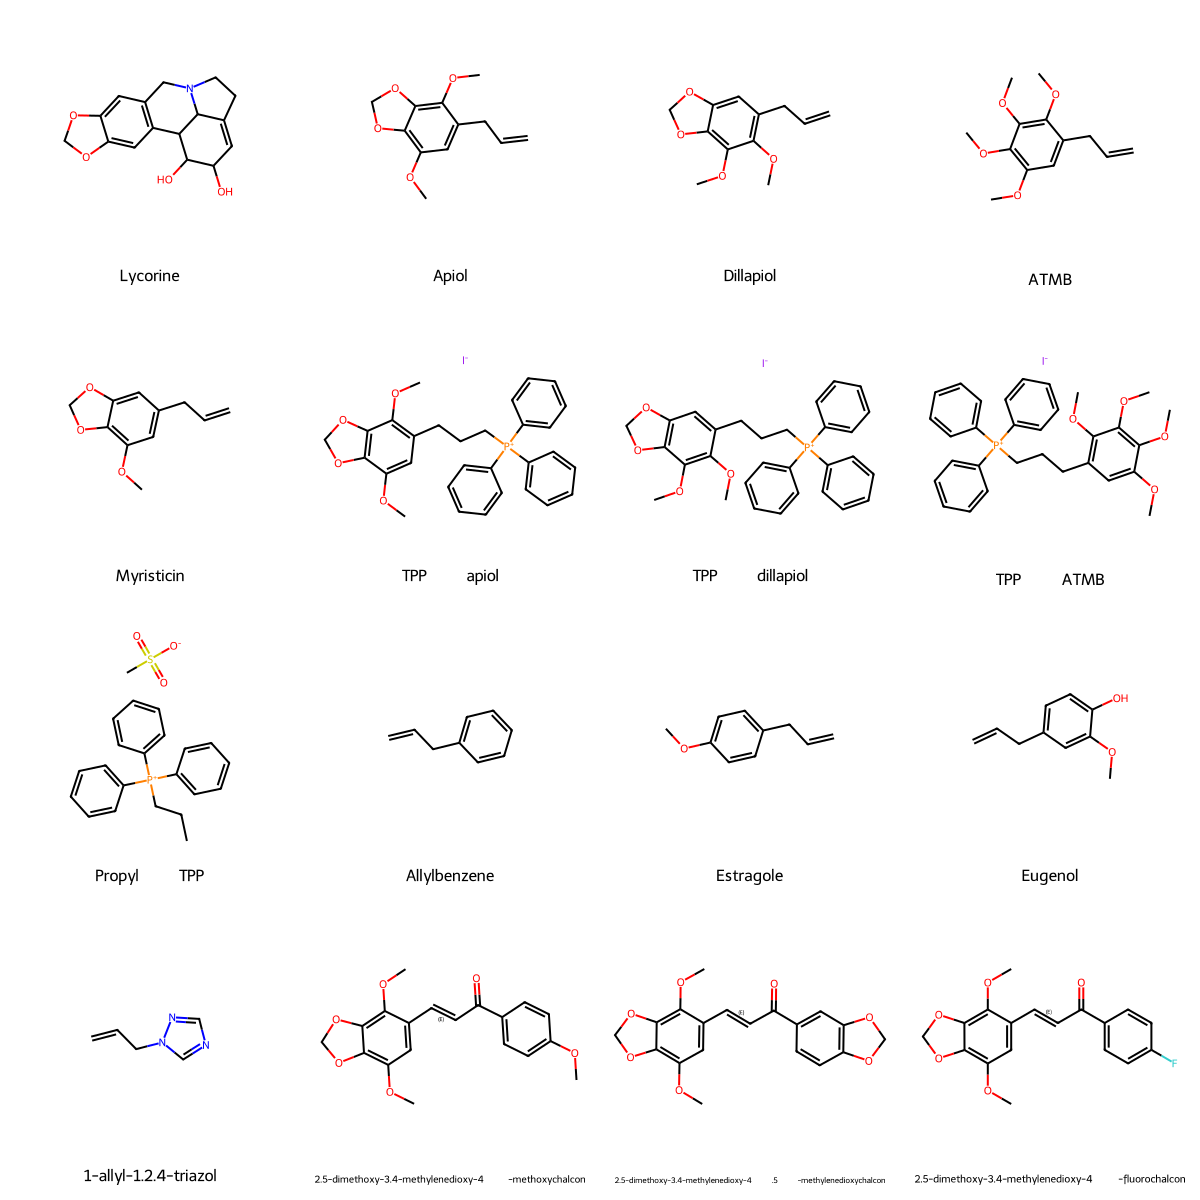

In [12]:
dm.to_image(mols=mols, legends=names)

In [13]:
fps_16 = [dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols]

X_test_fps_16 = pd.DataFrame(data=np.array(fps_16))
X_test_fps_16

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
fps_16_01 = [dm.to_fp(mol, nBits=1024 * 4) for mol in mols]

X_test_fps_16_01 = pd.DataFrame(data=np.array(fps_16_01))
X_test_fps_16_01

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение на попова с оценкой R^2 и RMSE

In [15]:
svr = svm.SVR()

In [16]:
kf = model_selection.RepeatedKFold(
    n_splits=5,
    n_repeats=1,
    random_state=42,
)

In [17]:
cv_results = model_selection.cross_validate(
    svr,
    X_train,
    y_train,
    scoring="r2",
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_estimator=True,
    return_train_score=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.3min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  7.9min remaining:  5.2min


[CV] END .................................................... total time= 4.2min
[CV] END .................................................... total time= 4.3min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.0min finished


In [18]:
cv_results_df = pd.DataFrame(cv_results).sort_values("test_score", ascending=False)
cv_results_df

,fit_time,score_time,estimator,test_score,train_score
0,199.868719,55.657945,SVR(),0.902251,0.937524
2,201.648026,53.489301,SVR(),0.901951,0.938362
3,201.800330,53.906208,SVR(),0.901497,0.940063
1,201.492654,53.907856,SVR(),0.901127,0.938363
4,200.881915,54.060589,SVR(),0.895607,0.939398


In [19]:
SVR_fps_LogP = cv_results_df.iloc[0, 2]

In [20]:
import pickle

# Save the model
with open("SVR_model_popova.pkl", "wb") as f:
    pickle.dump(SVR_fps_LogP, f)

In [ ]:
# Load the model
with open("SVR_fps_LogP_count.pkl", "rb") as f:
    SVR_fps_LogP2 = pickle.load(f)

### для Martel

In [25]:
y_pred_M_count = SVR_fps_LogP.predict(X_test)

In [26]:
metrics.r2_score(y_test, y_pred_M_count)

-0.25081343752278107

In [27]:
metrics.mean_squared_error(y_test, y_pred_M_count) ** 0.5

1.3177094563946972

In [28]:
metrics.mean_absolute_error(y_test, y_pred_M_count)

1.122272155636078

## LogP для молекул из статьи

In [21]:
y_pred_paper = SVR_fps_LogP.predict(X_test_fps_16)
y_pred_paper

array([1.20874144, 2.68397518, 2.73944543, 2.1231821 , 2.6875706 ,
       4.41325202, 4.42552764, 4.11200661, 3.89796018, 2.75506366,
       2.80541761, 2.17018144, 0.30529806, 3.42237451, 3.29253144,
       3.62665276])

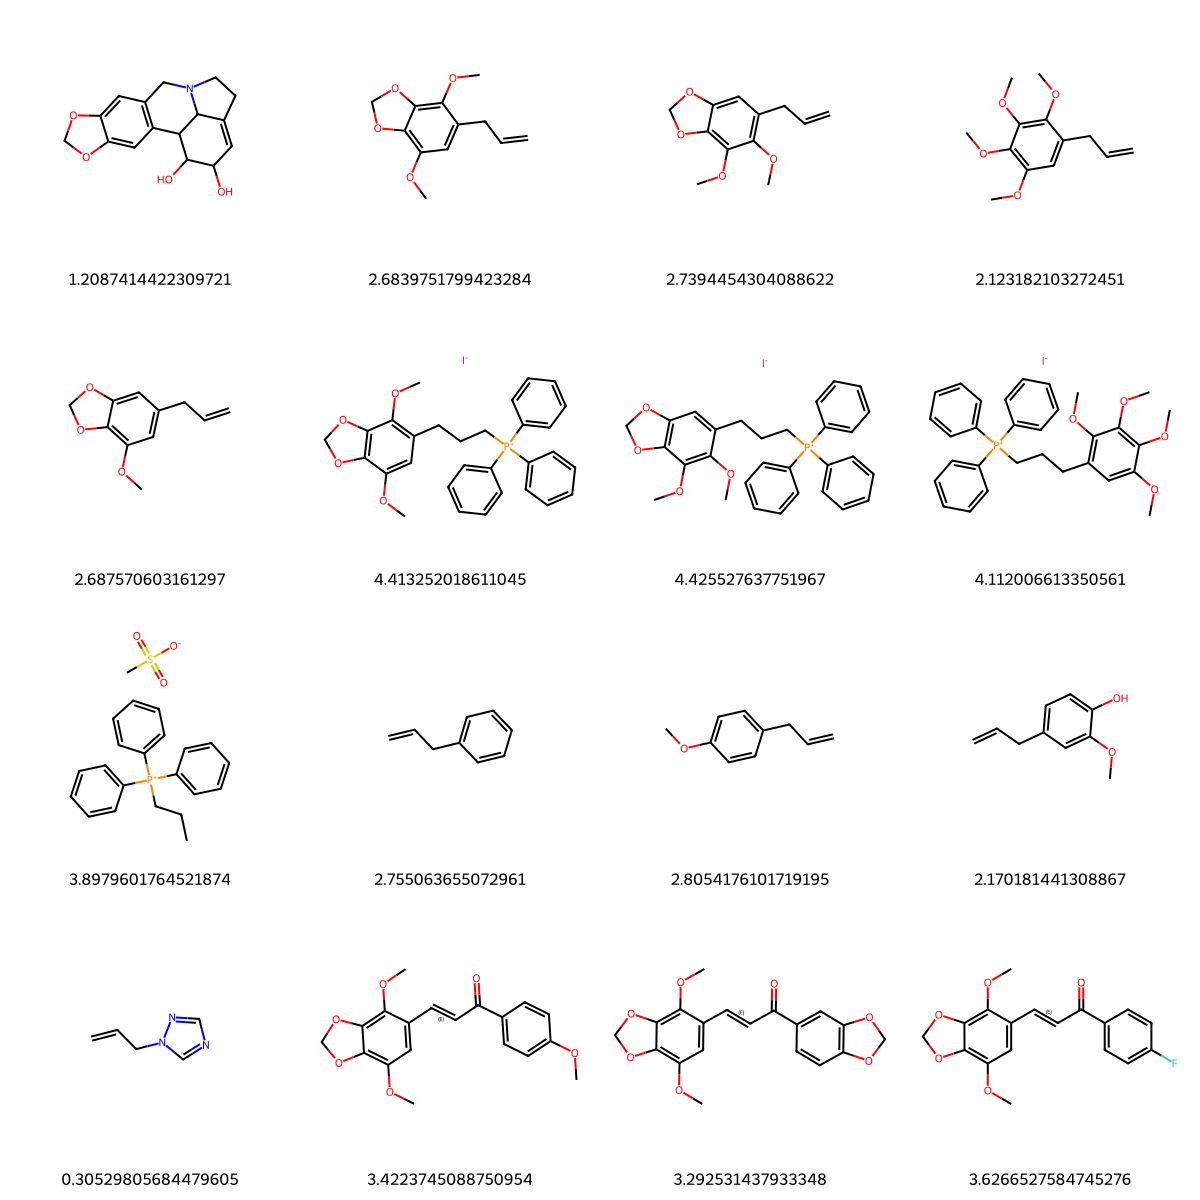

In [22]:
dm.to_image(mols=mols, legends=list(map(str, y_pred_paper)))

## сделаем для 0 и 1

In [30]:
cv_results_01 = model_selection.cross_validate(
    svr,
    X_train_01,
    y_train,
    scoring="r2",
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_estimator=True,
    return_train_score=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[CV] END .................................................... total time= 8.6min
[CV] END .................................................... total time= 8.6min
[CV] END .................................................... total time= 8.9min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.8min remaining:  8.5min


[CV] END .................................................... total time= 8.8min
[CV] END .................................................... total time= 9.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min finished


In [31]:
cv_results_df_01 = pd.DataFrame(cv_results_01).sort_values(
    "test_score", ascending=False
)
cv_results_df_01

,fit_time,score_time,estimator,test_score,train_score
2,455.308827,63.566550,SVR(),0.851975,0.923710
4,470.938955,60.195135,SVR(),0.846758,0.925117
3,483.347349,59.998111,SVR(),0.834800,0.926016
0,463.343180,62.037588,SVR(),0.830422,0.925738
1,455.837246,60.424281,SVR(),0.828229,0.927502


In [32]:
SVR_fps_LogP_01 = cv_results_df_01.iloc[0, 2]

In [33]:
y_pred_01 = SVR_fps_LogP_01.predict(X_train_01)  # предсказанные значения Popova

In [34]:
metrics.r2_score(y_train, y_pred_01)

0.9094938846297305

In [35]:
metrics.mean_squared_error(y_train, y_pred_01)

0.3014224657893737

In [36]:
metrics.mean_absolute_error(y_train, y_pred_01)

0.2968628601453614

In [37]:
# Save the model
with open("SVR_fps_LogP_01.pkl", "wb") as f:
    pickle.dump(SVR_fps_LogP_01, f)

# Load the model
with open("SVR_fps_LogP_01.pkl", "rb") as f:
    SVR_fps_LogP_01_2 = pickle.load(f)

### Martel

In [38]:
y_pred_01_M = SVR_fps_LogP_01.predict(X_test_01)  # предсказанные значения Popova

In [39]:
metrics.r2_score(y_test, y_pred_01_M)

-1.143926666190175

In [40]:
metrics.mean_squared_error(y_test, y_pred_01_M) ** 0.5

1.725155934743447

In [41]:
metrics.mean_absolute_error(y_test, y_pred_01_M)

1.5198202914703305

## RDKit LogP

In [43]:
Popova_logP_RDkit = [MolLogP(mols) for mols in mols_Popova]

In [46]:
metrics.r2_score(y_train, Popova_logP_RDkit)  # R^2 RDKit на Popova

0.7631616829369736

In [47]:
metrics.mean_squared_error(y_train, Popova_logP_RDkit) ** 0.5

0.8881265023003233

In [48]:
metrics.mean_absolute_error(y_train, Popova_logP_RDkit)

0.6208259990098302

In [49]:
Martel_logP_RDkit = [MolLogP(mols) for mols in mols_Martel]

In [51]:
metrics.r2_score(y_test, Martel_logP_RDkit), metrics.mean_squared_error(
    y_test, Martel_logP_RDkit
) ** 0.5, metrics.mean_absolute_error(y_test, Martel_logP_RDkit)

(-0.08458828421502251, 1.227031884161334, 0.9550537765205083)

## отфильтруем по MolWt и заряду

### создание нового DF

In [46]:
a = df_train

MW = df_train.MolWt
MW_mask = list(MW > 150)

a = a[MW_mask]
all(list(a.MolWt > 150))

True

In [48]:
plus_or_minus = []

count = 0

for i in a.canon_smi:

    if "+" in i:
        plus_or_minus.append(count)

    count += 1

len(plus_or_minus)

1415

In [52]:
ind = a.iloc[plus_or_minus].index
NEW_df = a.drop(index=ind)
NEW_df

,Unnamed: 0.1,canon_smi,Unnamed: 0,SMILES,Kow,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,1,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,1.885,16.859063,16.859063,0.067556,-1.980464,0.667213,...,0,0,0,0,0,0,0,0,0,0
1,1,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,2,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,2.190,12.870043,12.870043,0.041293,-1.584704,0.700523,...,0,0,0,0,0,0,0,0,0,0
2,2,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,3,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,2.100,13.474536,13.474536,0.062483,-1.645537,0.728839,...,0,0,0,0,0,0,0,0,0,0
3,3,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,4,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,1.470,11.975791,11.975791,0.293611,-1.310347,0.736884,...,0,0,0,0,0,0,0,0,0,1
4,4,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,5,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,-0.400,12.770676,12.770676,0.058604,-0.957338,0.410670,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14169,14169,O=c1[nH]c2cc(Cl)ccc2c(O)c1-c1cccc(Cc2ccc(CCN3C...,14201,O=c1[nH]c2cc(Cl)ccc2c(O)c1-c1cccc(Cc2ccc(CCN3C...,5.200,12.779701,12.779701,0.030382,-0.338854,0.411576,...,0,0,0,0,0,0,0,0,0,0
14171,14171,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,14203,S=C(NN=C(c1ccccn1)c1ccccn1)Nc1ccccc1,1.960,5.284200,5.284200,0.394039,0.394039,0.436016,...,0,0,0,0,0,0,0,0,0,0
14172,14172,S=C=NCCCCCCCCCCc1ccccc1,14204,S=C=NCCCCCCCCCCc1ccccc1,6.820,4.530743,4.530743,0.861682,0.861682,0.296905,...,0,0,0,0,0,0,0,0,8,0
14173,14173,S=C=NCCCCCCCCc1ccccc1,14205,S=C=NCCCCCCCCc1ccccc1,5.810,4.517097,4.517097,0.854678,0.854678,0.350684,...,0,0,0,0,0,0,0,0,6,0


In [55]:
y_train_new = NEW_df.Kow

In [54]:
smiles_Popova_new = NEW_df.SMILES

mols_Popova_new = [dm.to_mol(smiles) for smiles in smiles_Popova_new]

fps_Popova_new = [
    dm.to_fp(mol, fp_type="ecfp-count", nBits=1024 * 4) for mol in mols_Popova_new
]

X_train_new = pd.DataFrame(data=np.array(fps_Popova_new))  # сделаем не только с 0 и 1
X_train_new

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### обучение на новом DF

In [56]:
cv_results_new = model_selection.cross_validate(
    svr,
    X_train_new,
    y_train_new,
    scoring="r2",
    cv=kf,
    n_jobs=-1,
    verbose=2,
    return_estimator=True,
    return_train_score=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


In [57]:
cv_results_df_new = pd.DataFrame(cv_results_new).sort_values(
    "test_score", ascending=False
)
cv_results_df_new

,fit_time,score_time,estimator,test_score,train_score
2,115.923992,33.227899,SVR(),0.922000,0.950967
1,116.785170,33.365593,SVR(),0.919626,0.951384
0,115.135142,31.861835,SVR(),0.913702,0.952308
4,115.549334,31.787843,SVR(),0.912520,0.952402
3,116.922679,33.455738,SVR(),0.910653,0.952197


In [58]:
SVR_fps_LogP_new = cv_results_df_new.iloc[0, 2]

In [59]:
SVR_fps_LogP_new.score(X_test, y_test)

-0.14992846165787221

In [60]:
y_pred_M_count_new = SVR_fps_LogP_new.predict(X_test)

In [62]:
metrics.mean_squared_error(y_test, y_pred_M_count_new) ** 0.5

1.2634521684429232

In [63]:
metrics.mean_absolute_error(y_test, y_pred_M_count_new)

1.07281120467493

In [65]:
# Save the model
with open("SVR_fps_LogP_new.pkl", "wb") as f:
    pickle.dump(SVR_fps_LogP_new, f)

# Load the model
with open("SVR_fps_LogP_new.pkl", "rb") as f:
    SVR_fps_LogP_new2 = pickle.load(f)

In [66]:
y_pred_paper_new = SVR_fps_LogP_new.predict(X_test_fps_16)
y_pred_paper_new

array([1.13069298, 2.47179938, 2.58217397, 2.24422816, 2.4700621 ,
       4.73903799, 4.76633049, 4.43378977, 4.14598547, 2.72858259,
       2.66646555, 2.15484815, 0.64457616, 3.31174932, 3.16705422,
       3.46104765])

In [67]:
y_pred_paper

array([1.20874144, 2.68397518, 2.73944543, 2.1231821 , 2.6875706 ,
       4.41325202, 4.42552764, 4.11200661, 3.89796018, 2.75506366,
       2.80541761, 2.17018144, 0.30529806, 3.42237451, 3.29253144,
       3.62665276])